In [7]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from scipy.stats import norm
pd.set_option('display.max_colwidth', None)
from scipy.optimize import minimize
from scipy.optimize import fsolve
from scipy.integrate import quad
import scipy.integrate as integrate
import scipy.special as special
import math
import random
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (11, 5)  #set default figure size
import quantecon as qe
from mpl_toolkits.mplot3d import Axes3D
from math import sqrt
from pylab import plot, show, grid, xlabel, ylabel

## 3-State CTMC
https://en.wikipedia.org/wiki/Continuous-time_Markov_chain

In [481]:
# The statespace
states = ["Mild","Moderate","Harsh"]

# Possible sequences of events
transitionName = [["LL","LM","LH"],["ML","MM","MH"],["HL","HM","HH"]]

# Probabilities matrix (transition matrix)
transition_matrix = [[0  ,0.7,0.3],
                     [0.6,0  ,0.4],
                     [0.3,0.7,0  ]]

experiment_time = 10000
# State exponential distribution
state_lambdas = [2000,5000,3000]
start_p = [0.3,.5,.2]

In [482]:
def generate_path_CTMC(transition_matrix, state_lambdas, start_p, experiment_time, output_length=1):
    """
    Generates output_length number of paths (with state and times) based on the parameters for the CTMC
    """
    n = len(state_lambdas)
    paths = []
    for i in range(output_length):
        curr_time = 0
        curr_state = np.random.choice(np.arange(n), p=start_p)

        path = []
        while curr_time < experiment_time:
            curr_time = min(curr_time + np.random.exponential(state_lambdas[curr_state]),experiment_time)
            path.append((curr_state,int(round(curr_time,0))))
            curr_state = np.random.choice(np.arange(n), p=transition_matrix[curr_state])
        paths.append(path)
    return paths

In [483]:
paths = generate_path_CTMC(transition_matrix, state_lambdas, start_p, experiment_time, 100)
paths

[[(2, 2817), (1, 8088), (0, 10000)],
 [(1, 352), (2, 10000)],
 [(1, 4335), (0, 8596), (2, 10000)],
 [(0, 1111), (1, 2323), (0, 8291), (1, 9400), (0, 10000)],
 [(1, 10000)],
 [(0, 1677), (1, 2244), (2, 5666), (1, 10000)],
 [(0, 778), (1, 8138), (2, 10000)],
 [(1, 1483), (2, 2171), (0, 2798), (2, 3160), (0, 6214), (1, 10000)],
 [(2, 6670), (1, 8676), (0, 10000)],
 [(1, 5619), (2, 9046), (1, 9320), (0, 10000)],
 [(1, 10000)],
 [(0, 2297), (1, 6104), (0, 7271), (1, 10000)],
 [(0, 2009), (1, 5147), (0, 8282), (1, 10000)],
 [(0, 887), (1, 10000)],
 [(0, 30), (1, 3025), (0, 3593), (1, 8201), (0, 8556), (1, 10000)],
 [(2, 556), (1, 1825), (0, 6189), (1, 10000)],
 [(0, 3186), (1, 4194), (2, 6674), (0, 7197), (2, 8458), (1, 10000)],
 [(1, 6264), (0, 6476), (2, 7535), (0, 7602), (1, 8911), (0, 10000)],
 [(1, 2891), (0, 3132), (1, 3534), (2, 3689), (1, 10000)],
 [(1, 10000)],
 [(1, 1531), (0, 6864), (1, 8782), (0, 9243), (2, 10000)],
 [(0, 1315), (1, 4836), (2, 7187), (1, 10000)],
 [(2, 312), (1, 

In [484]:
def brownian(x0, n, dt, delta, net_increase, out=None):
    """
    Generate an instance of Brownian motion (i.e. the Wiener process):

        X(t) = X(0) + N(0, delta**2 * t; 0, t)

    where N(a,b; t0, t1) is a normally distributed random variable with mean a and
    variance b.  The parameters t0 and t1 make explicit the statistical
    independence of N on different time intervals; that is, if [t0, t1) and
    [t2, t3) are disjoint intervals, then N(a, b; t0, t1) and N(a, b; t2, t3)
    are independent.
    
    Written as an iteration scheme,

        X(t + dt) = X(t) + N(0, delta**2 * dt; t, t+dt)


    If `x0` is an array (or array-like), each value in `x0` is treated as
    an initial condition, and the value returned is a numpy array with one
    more dimension than `x0`.

    Arguments
    ---------
    x0 : float or numpy array (or something that can be converted to a numpy array
         using numpy.asarray(x0)).
        The initial condition(s) (i.e. position(s)) of the Brownian motion.
    n : int
        The number of steps to take.
    dt : float
        The time step.
    delta : float
        delta determines the "speed" of the Brownian motion.  The random variable
        of the position at time t, X(t), has a normal distribution whose mean is
        the position at time t=0 and whose variance is delta**2*t.
    out : numpy array or None
        If `out` is not None, it specifies the array in which to put the
        result.  If `out` is None, a new numpy array is created and returned.

    Returns
    -------
    A numpy array of floats with shape `x0.shape + (n,)`.
    
    Note that the initial value `x0` is not included in the returned array.
    """

    x0 = np.asarray(x0)

    # For each element of x0, generate a sample of n numbers from a
    # normal distribution.
    r = norm.rvs(size=x0.shape + (n,), scale=delta*sqrt(dt))

    # If `out` was not given, create an output array.
    if out is None:
        out = np.empty(r.shape)

    # This computes the Brownian motion by forming the cumulative sum of
    # the random samples. 
    np.cumsum(r, axis=-1, out=out)

#     out = out + 1000
    # Add the initial condition.
    out += np.expand_dims(x0, axis=-1)
    out += np.repeat(np.arange(n).reshape(1,-1),len(x0),axis=0)*net_increase/n

    return np.concatenate((x0.reshape((-1,1)),out),axis=1)

In [1]:
# # Total time.
# T = 10000.0
# # The Wiener process parameter.
# delta = .07
# net_increase = 150.0
# x_0 = 50
# mu = net_increase/T
# # Number of steps.
# N = 10000
# # Time step size
# dt = T/N
# # Number of realizations to generate.
# m = 50
# # Create an empty array to store the realizations.
# x = np.empty((m,N+1))
# # Initial values of x.
# x[:, 0] = x_0

# brownian(x[:,0], N, dt, delta, net_increase, out=x[:,1:])
# x = brownian(x[:,0], N, dt, delta, net_increase)
# t = np.linspace(0.0, N*dt, N+1)
# for k in range(m):
#     plot(t, x[k])
# xlabel('t', fontsize=16)
# ylabel('x', fontsize=16)
# grid(True)
# show()

In [532]:
# The Wiener process parameter.
delta = .25
net_increases = [80.0,200.0,500.0]
x_0 = 50
mus = [i/T for i in net_increases]

In [533]:
X_t = []
for i in range(100):
    start = 0
    x = np.empty((N+1))
    x[0] = x_0
    for env, end in paths[i]:
        new_path = brownian([x[start]], N, dt, delta, net_increases[env])
        x[start:end+1] = new_path[0][:end-start+1]
        start = end
    X_t.append(x)

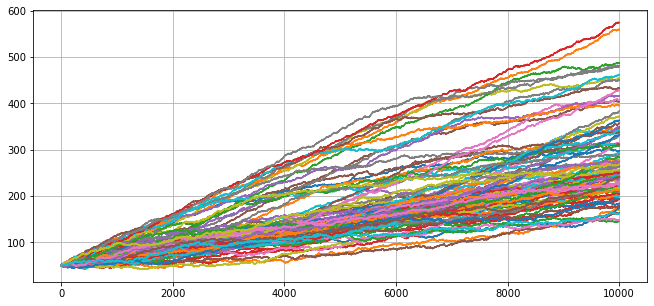

In [534]:
for k in range(100):
    plot(X_t[k])
grid(True)

In [535]:
paths[0]

[(2, 2817), (1, 8088), (0, 10000)]

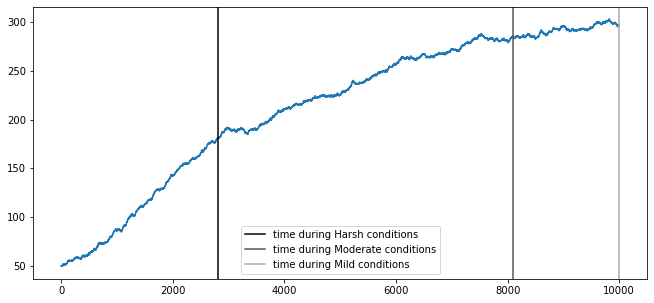

In [536]:
plot(X_t[0])
for env, time in paths[0]:
    plt.axvline(time, 0, 1, label=f'time during {states[env]} conditions',color = str(1-(env+1)/3))
plt.legend()

plt.show()

In [465]:
import pickle

def save_in_pickle(save_object, save_file):
    with open(save_file, "wb") as pickle_out:
        pickle.dump(save_object, pickle_out)

def load_from_pickle(pickle_file):
    with open(pickle_file, "rb") as pickle_in:
        return pickle.load(pickle_in)

In [537]:
save_in_pickle(paths,'paths.pkl')
save_in_pickle(X_t,'X_t.pkl')